In [1]:
import pandas as pd
import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Train-Test Split of Images**

In [3]:
os.listdir("EuroSAT")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'EuroSAT'

In [ ]:
traindata = pd.read_csv("EuroSAT/train.csv")
testdata = pd.read_csv("EuroSAT/test.csv")

In [ ]:
traindata.head()

In [ ]:
testdata.head()

In [ ]:
os.mkdir("EuroSATCNN")

In [ ]:
import shutil
os.mkdir("EuroSATCNN/Train")
for i in range(len(traindata)):
    if traindata.ClassName[i] in os.listdir("EuroSATCNN/Train"):
        src=f"EuroSAT/{traindata.Filename[i]}"
        dst=f"EuroSATCNN/Train/{traindata.ClassName[i]}/"
        shutil.copy(src, dst)
    else:
        os.mkdir(f"EuroSATCNN/Train/{traindata.ClassName[i]}")
        src=f"EuroSAT/{traindata.Filename[i]}"
        dst=f"EuroSATCNN/Train/{traindata.ClassName[i]}/"
        shutil.copy(src, dst)
os.mkdir("EuroSATCNN/Test")
for i in range(len(testdata)):
    if testdata.ClassName[i] in os.listdir("EuroSATCNN/Test"):
        src=f"EuroSAT/{testdata.Filename[i]}"
        dst=f"EuroSATCNN/Test/{testdata.ClassName[i]}/"
        shutil.copy(src, dst)
    else:
        os.mkdir(f"EuroSATCNN/Test/{testdata.ClassName[i]}")
        src=f"EuroSAT/{testdata.Filename[i]}"
        dst=f"EuroSATCNN/Test/{testdata.ClassName[i]}/"
        shutil.copy(src, dst)

In [ ]:
traindata.ClassName.value_counts()

In [ ]:
testdata.ClassName.value_counts()

### 1. Prepping Images for CNN

* **Loading Train and Test Images along with classes from CNN Data Folder**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* **Defining of Data Gen for Train and Test**

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

* **Loading Train & Test Data**

In [6]:
x_train = train_datagen.flow_from_directory("EuroSATCNN/Train",target_size=(256,256),color_mode='rgb',class_mode="categorical",batch_size=32)

Found 12000 images belonging to 10 classes.


In [7]:
x_test = test_datagen.flow_from_directory("EuroSATCNN/Test",target_size=(256,256),color_mode='rgb',class_mode="categorical",batch_size=32)

Found 2000 images belonging to 10 classes.


* **Visualization of data generator Images**

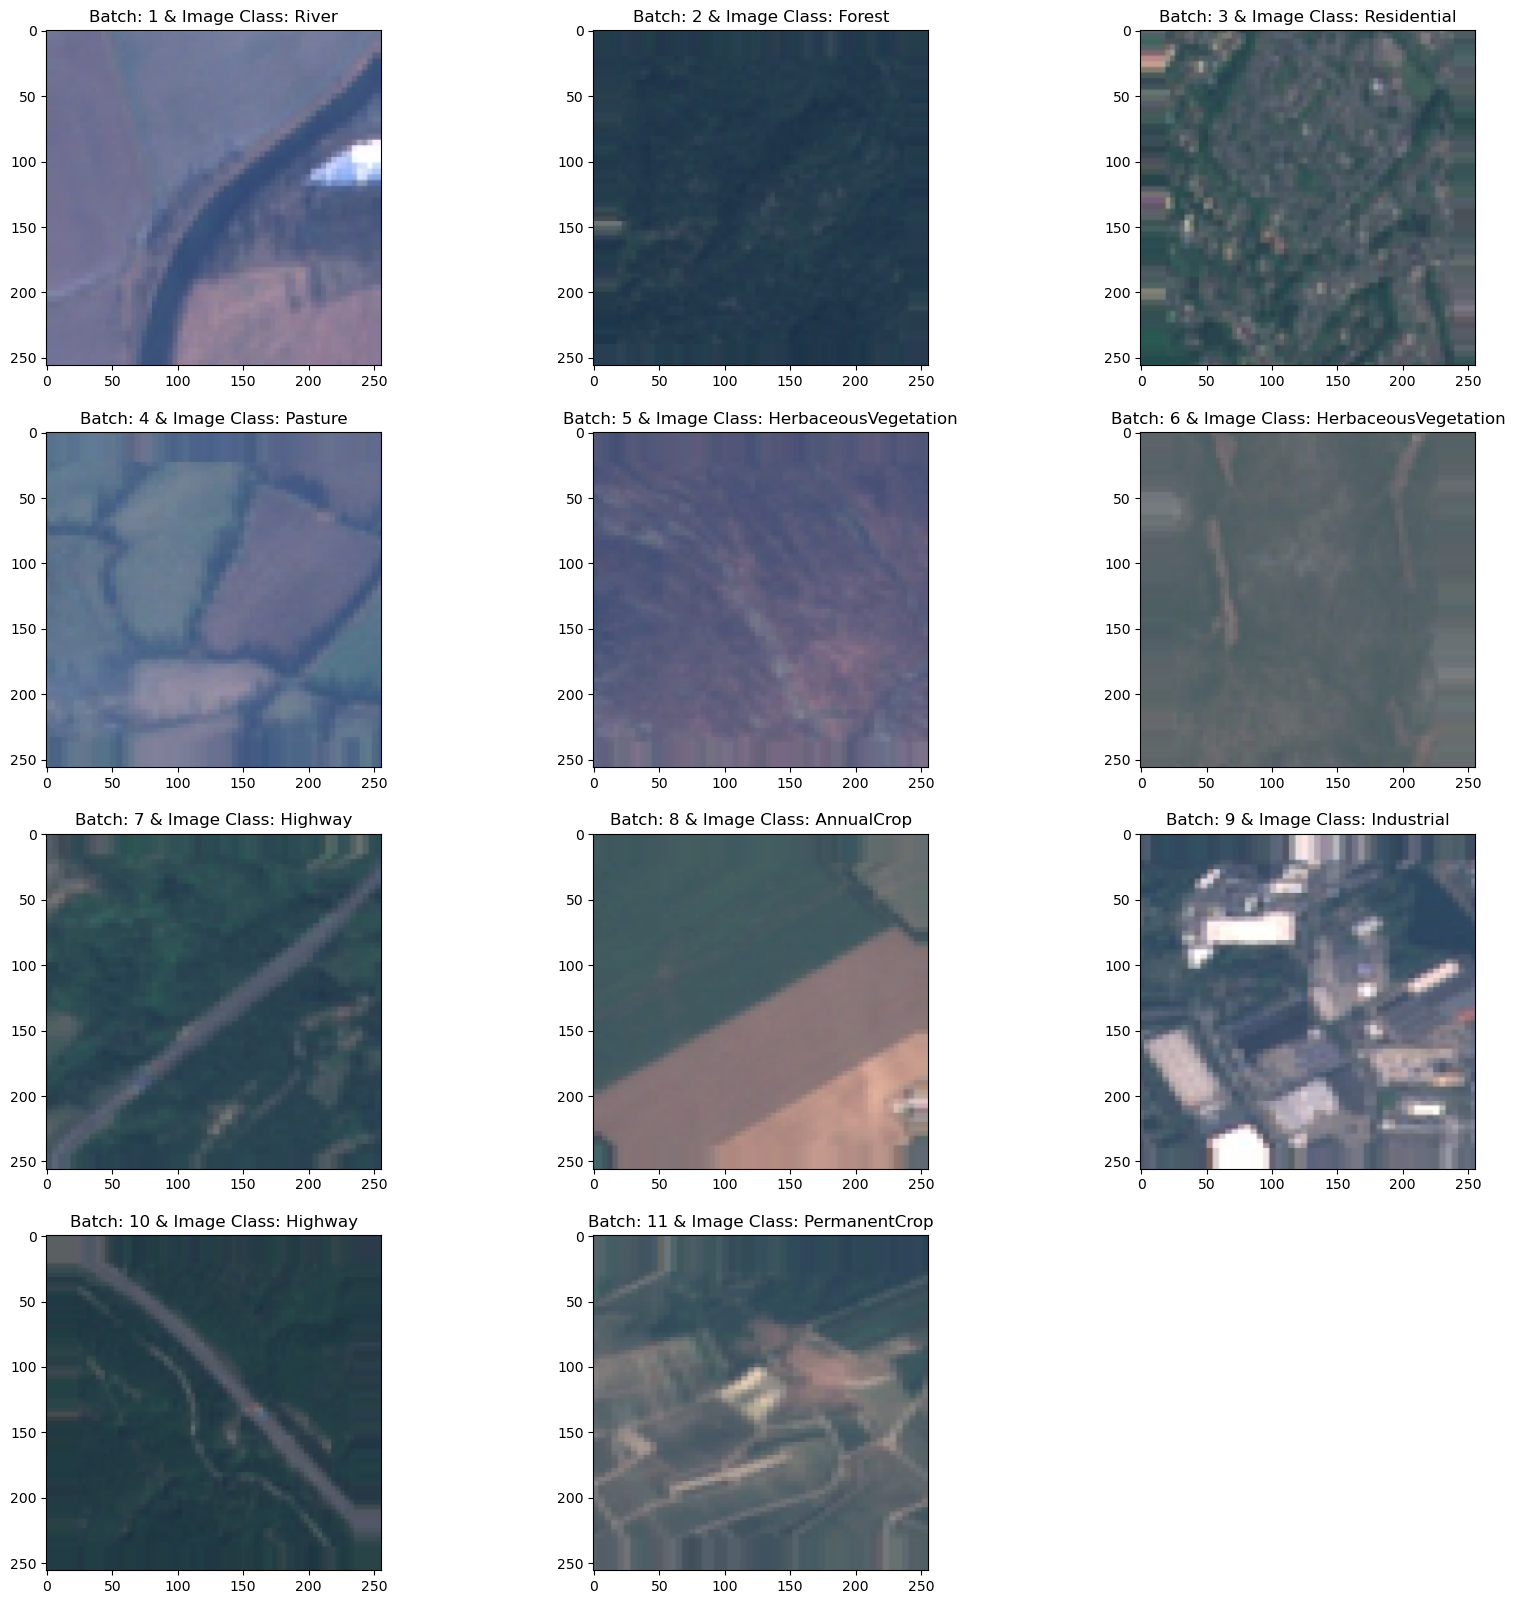

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))
for i,image in enumerate(x_train, 1):
    if(i==12):
        break
    plt.subplot(4,3,i) #
    plt.imshow(image[0][15])
    classes = {v: k for k, v in x_train.class_indices.items()}
    name = classes[np.argmax(image[1][15])]
    plt.title("Batch: {} & Image Class: {}".format(i, name))

### 2. Model

**CNN**

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPool2D, Dropout, Flatten, Dense

* **Model Intialization**

In [ ]:
cnn = Sequential(name='EuroSATImageClassification')

* **Convolution Layer**

In [ ]:
cnn.add(Conv2D(input_shape=(256,256,3), filters = 32, kernel_size=(3,3), strides=(2,2), name='Conv1'))
cnn.add(Activation('relu'))
cnn.summary()

* **Pooling**

In [ ]:
cnn.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool1'))
cnn.summary()

* **Adding Extra Convolution+Pooling Layer (Optional) - To control the Flatten Output**

In [ ]:
cnn.add(Conv2D(filters=16, kernel_size=(2,2), strides=(2,2), name='Conv2'))
cnn.add(Activation('relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool2'))

In [ ]:
cnn.add(Conv2D(filters=16, kernel_size=(2,2), strides=(2,2), name='Conv3'))
cnn.add(Activation('relu'))
cnn.add(MaxPool2D(pool_size=(2,2), strides=(1,1), name='Pool3'))

In [ ]:
cnn.summary()

* **Flatten Layer**

In [ ]:
cnn.add(Flatten(name='Flatten'))

In [ ]:
cnn.summary()

* **Model Visualization**

In [ ]:
from keras.utils import plot_model
plot_model(cnn,show_layer_names=True,show_shapes=True)

**ANN**

* **Fully Connected Layer**

* Adding Hidden Layers for ANN

In [ ]:
cnn.add(Dense(kernel_initializer="random_uniform", activation="relu", units=7000))
cnn.add(Dense(kernel_initializer="random_uniform", activation="relu", units=3500))
cnn.add(Dense(kernel_initializer="random_uniform", activation="relu", units=1750))

* **Output Layer**

In [ ]:
cnn.add(Dense(kernel_initializer='random_uniform', activation='softmax', units=10))

In [ ]:
cnn.summary()

* **Model Compile Parameters**

In [ ]:
cnn.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

* **Final Model Visualization**

In [ ]:
from keras.utils import plot_model
plot_model(cnn,show_layer_names=True,show_shapes=True)

**Training Model**

In [ ]:
cnn.fit(x_train, epochs=10, validation_data=x_test)

* **Model Performance**

In [ ]:
import matplotlib.pyplot as plt
plt.plot(list(range(0,10)), cnn.history.history['accuracy'], label = "Train Accuracy")
plt.plot(list(range(0,10)), cnn.history.history['val_accuracy'], label = "Test Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

**Real time Prediction**
   * **Prediction on given Images**

In [ ]:
import cv2
import numpy as np

def detect(frame):
    img=cv2.resize(frame,(256,256))
    #scaling to 0 to 1 range
    if(np.max(img)>1):
        img = img/255.0
    img = np.array([img])
    prediction = cnn.predict(img)[0]
    classes = {v: k for k, v in x_train.class_indices.items()}
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    print()
    print("Prediction:",classes[np.argmax(prediction)])
    print()
    print("=================================================================")

In [ ]:
pwd

* **Taking Sample Images from Test Images given**

In [ ]:
import glob
images = glob.glob("EuroSATCNN/Test Samples/*")

In [ ]:
images

* **Applying above detect function on Images**

In [ ]:
import matplotlib.image as mpimg # to read image in array

for img in images:
    image = mpimg.imread(r'{}'.format(img))
    detect(image) # prediction function

**Saving Model**

In [ ]:
import joblib

joblib.dump(cnn, "cnn_EuroSAT.h5")

In [ ]:
detect(mpimg.imread(r'EuroSATCNN/Test Samples\\Industrial_115.jpg'))

In [ ]:
import joblib
cnn = joblib.load("cnn_EuroSAT.h5")

In [9]:
classes = {v: k for k, v in x_train.class_indices.items()}

In [10]:
classes

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

**Real Time Prediction**

In [13]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
import cv2
import joblib
cnn = joblib.load("cnn_EuroSAT.h5")
def detect(frame):
    img=cv2.resize(frame,(256,256))
    #scaling to 0 to 1 range
    if(np.max(img)>1):
        img = img/255.0
    img = np.array([img])
    prediction = cnn.predict(img)[0]
    classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial',
               5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
    print("Given Image:")
    print()
    plt.figure(figsize=(3,3))
    plt.imshow(frame)
    plt.show()
    print()
    print("Prediction:",classes[np.argmax(prediction)])
    print()
    print("=================================================================")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step
Given Image:



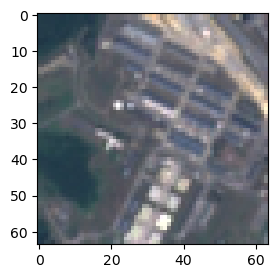


Prediction: Highway



In [14]:
detect(mpimg.imread(r'EuroSATCNN/Test Samples\\Industrial_115.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Given Image:



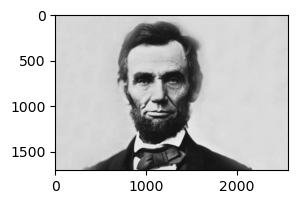


Prediction: Industrial



In [16]:
detect(mpimg.imread("Abrahm.jpg"))